# 3-6. 모델을 더 완벽하게 만드는 방법 : KerasTuner
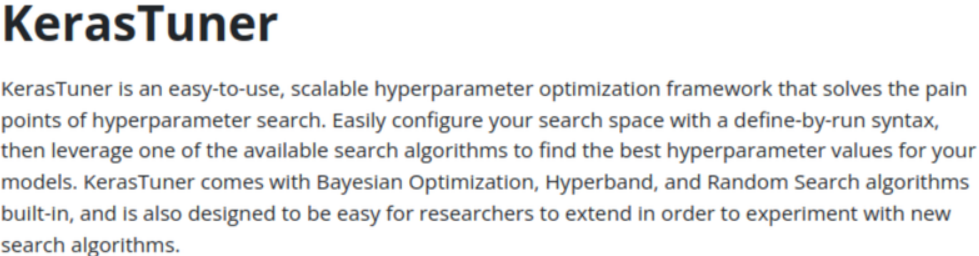

우리가 볼 첫번째 MLOps는 하이퍼파라미터 튜닝입니다. 그중에서 우리가 사용할 툴은 KerasTuner입니다.

KerasTuner는 Keras뿐만 아니라 scikit-learn과 같은 모델에서도 커스터마이징해서 사용할 수 있는 툴이며 하이퍼파라미터 튜닝을 자동으로 할 수 있게 도와줍니다.

기존 모델에서 하이퍼파라미터 튜닝을 진행한다고 했을 때 딥러닝의 경우 일일이 바꿔가면서 함수를 만들고 정리했습니다. 그러나 KerasTuenr를 사용하고 범위를 결정하는 함수를 잘 선택한다면 하이퍼파라미터 튜닝을 원하는대로 할 수 있습니다.

그렇다면 KerasTuner를 사용하러 떠나볼까요?

이번 실습은 MNIST로 간단하게 할 수 있는 하이퍼파라미터 튜닝작업입니다!

우선 디렉토리 먼저 만들어놓도록 하겠습니다.

이번 실습에 앞서 우선 KerasTuner를 설치하겠습니다.

In [ ]:
# !mkdir ~/aiffel/mlops

In [1]:
!pip install keras-tuner

In [2]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os

우리가 이번에 사용할 데이터셋은 MNIST입니다. keras에 내장되어 있는 datasets으로 불러오겠습니다!

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


CNN을 사용할 예정이라 차원 수를 하나 더 추가해줍니다.

또한 label을 categorical을 활용해 변환합니다.

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [7]:
X_train = x_train.reshape(-1,28, 28, 1) 
X_test = x_test.reshape(-1,28,28,1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [8]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

scikit-learn에 내장되어 있는 train_test_split으로 train data와 validation data를 나누어줍니다.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)

(48000, 28, 28, 1)


이번에는 제가 짠 DeepTuner를 살펴보겠습니다!

DeepTuner의 경우 kerastuner.Tuner를 인자로 하는 class이며 class에서 수행하는 함수는 run_trial, save_model load_model입니다.

run_trial 함수에서 제일 중요한 부분은 hypermodel과 trial입니다.

KerasTuner에서의 hypermodel은 모델을 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델입니다. hypermodel의 경우 hp라는 인수를 활용해서 keras.Model을 생성합니다.
즉 hypermodel은 우리가 만들고 싶은 모델을 쌓는 과정을 거치는데 이때 하이퍼파라미터 튜닝에 대한 검색공간을 만들어줄때 hp라는 인수를 사용해서 만든 모델입니다.
hypermodel의 경우 build 메소드를 활용하면 모델이 빌드가 되면서 하이퍼파라미터 튜닝이 시작합니다.

trial의 경우에는 Oracle에 속하는 class입니다.

Oracle이란 KerasTuner의 모든 검색 알고리즘에서 사용하는 기본 클래스이며 크게 RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle이 있습니다.

쉽게 설명하면 Oracle은 KerasTuner가 하이퍼파라미터를 정할 때 사용하는 알고리즘이라고 생각하시면 됩니다!
여기서 trial.hyperparameter는 Oracle이 찾아야 하는 하이퍼파라미터입니다. 즉 hypermodel에서의 hp입니다.
제가 model.fit()을 할때 batch_size도 고를 수 있게 만들었습니다.

In [11]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

이번에는 build_model쪽을 보도록 하겠습니다.

build_model은 위에서 설명한것처럼 hypermodel을 만들어줘야 합니다. 제가 만든 hypermodel은 총 2가지 기법이 들어가 있으며 주의사항도 1가지 있습니다.

우선 주의사항부터 말씀드리면 해당 모델의 경우 hypermodel이기 때문에 Input지정이 필수입니다!
그렇기에 여러분들이 넣고 싶은 모델에 대한 shape을 꼭 기재해주셔야 합니다!

제가 사용한 첫번째 기법은 바로 layer의 숫자도 KerasTuner에게 맡겼습니다.
for문을 확인해보겠습니다

첫번째 for문의 경우 hp.Int로 만들어 검색공간은 정수로 만들고 가장 작은값을 1로 가장 큰값을 10으로 두었습니다.
이렇게 설정하면 최소 1개에서 최소 10개의 layer를 쌓을 수 있게 설정할 수 있습니다.

제가 쌓고싶은 layer는 conv2D인데 kernel_size는 (3,3)이며 차원수는 최소 32에서 최대 256으로 바꾸었습니다.

두번째 for문을 살펴보겠습니다. 두번째 for문도 최소 1개에서 3개로 설정했지만 Dense Layer의 경우 나올 수 있는 차원을 32,64,128,256중 1개를 선택하도록 만들었습니다.

이러한 방식으로 hypermodel을 만들면 하고싶은 하이퍼 파라미터 튜닝을 진행할 수 있습니다.

In [12]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

마지막으로 keras_tuner를 정의하고 탐색하는것까지 보도록 하겠습니다.

저는 이번 모델의 경우 BayesianOptimizationOracle을 사용할 예정이며 목표는 accuracy와 max로 둘 예정입니다. 실제 trial은 10번으로 지정할 것입니다.

hypermodel은 build_model을 넣어주시고 project이름도 작성해주세요.

마지막으로 search함수에 X_train, Y_train, validation data, epoch을 넣고 탐색합니다!

In [13]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 47s]
accuracy: 0.9767500162124634

Best accuracy So Far: 0.984499990940094
Total elapsed time: 00h 09m 47s


가장 좋은 모델을 뽑는 방법은 KerasTuner.get_best_hyperparamters를 이용해서 가장 좋은 하이퍼파라미터를 뽑아내는 작업입니다
하이퍼파라미터를 뽑았으면 build_model()에 집어넣어 가장 좋은 모델을 선언합니다.

그렇다면 여러분들이 만든 가장 좋은 모델을 확인해볼까요?

In [14]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 26, 26, 102)       1020      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 24, 42)        38598     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 22, 22, 67)        25393     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 20, 20, 37)        22348     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 18, 18, 52)        17368     
_________________________________________________________________
flatten_11 (Flatten)         (None, 16848)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)             

최고의 하이퍼 파라미터만 뽑았기 때문에 아직 모델학습이 되지 않았습니다!
이번에 epoch을 5번정도 주어서 모델학습을 진행합니다!

만일 여러분들이 무거운 모델을 돌릴 경우 하이퍼파라미터 튜닝작업이 매우 느려질 수 있습니다.
그때의 경우 하이퍼파라미터 튜닝할때 epoch을 3-4정도로 작게 준 다음 최고의 하이퍼파라미터를 뽑아낸 다음
본격적인 모델학습때 epoch을 넉넉하게 주는 것도 방법입니다!

In [16]:
model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1857 - accuracy: 0.9522
Epoch 2/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0476 - accuracy: 0.9857
Epoch 3/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0355 - accuracy: 0.9887
Epoch 4/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0260 - accuracy: 0.9918
Epoch 5/5
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0192 - accuracy: 0.9943


모델 평가를 진행해볼까요?

In [17]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0713 - accuracy: 0.9807


[0.07132269442081451, 0.9807000160217285]

이제 모델을 저장할 차례입니다.

우리가 이전까지 자주 사용한 저장방법은 HDF5파일 (.h5)로 저장하는 방법이었습니다.

HDF파일로 저장하는 방식은 이전 Keras에서 모델을 저장하는 방식이었으나 사실 이 방법은 TensorFlow나 Keras에서 그다지 선호하지 않는 저장방식입니다.

TensorFlow의 경우 공식적으로 지원하는 모델 저장방식은 SavedModel입니다.

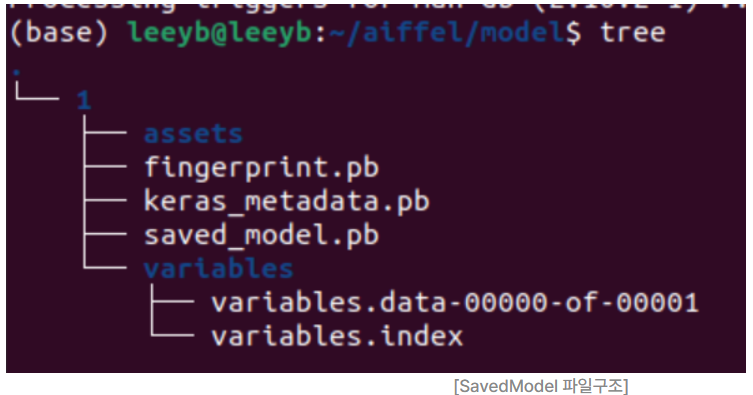

SavedModel은 .h5파일처럼 모델의 가중치와 모델을 전부 하나의 파일로 관리하는 방식이 아닌 모델, 가중치를 따로 구분해서 저장하는 방식입니다.

SavedModel은 크게 3가지로 구성되어 있습니다.

- saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 내보낸 모델 그래프 구조를 포함하고 있습니다.
- variables : 내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함하고 있습니다
- assets : 내보낸 모델을 불러올 때 추가적인 파일이 필요한 경우 이 폴더에 파일이 생성됩니다.

이 방식으로 진행한다면 모델을 배포할 때 유리합니다.

Keras의 경우 .keras파일을 선호합니다. .keras파일은 .h5파일과 마찬가지로 가중치와 모델을 전부 하나의 파일로 관리합니다.

In [18]:
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model/assets


# 3-7. 이제는 모델을 배포할 차례! : TFServing & TFLite

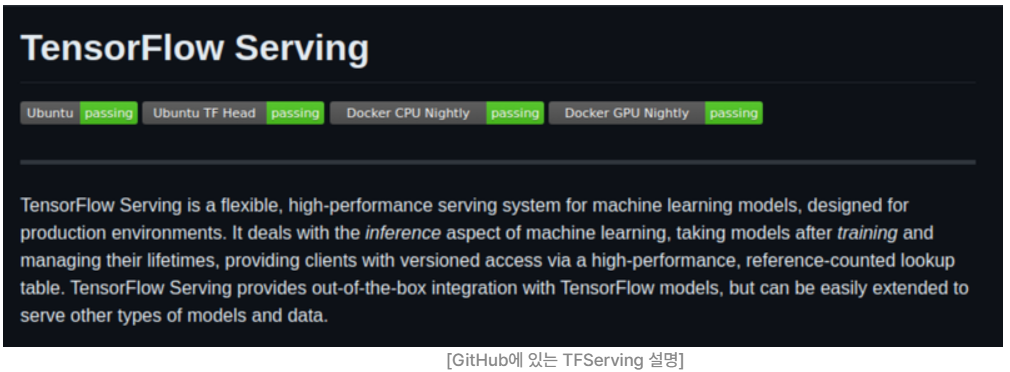

모델을 만들었다면 이제는 배포를 진행해봐야죠!

배포를 진행하는 방법은 크게 2가지로 나눌 수 있습니다.

- 클라우드를 활용해서 모델을 배포하는 방식
- 경량화된 모델을 만들어서 휴대폰같은 디바이스에서도 모델이 실행되게 만드는 방식

TensorFlow는 첫번째 방식을 TFServing을 통해서 가능하게 만들며 2번째 방식은 TFLite방식으로 가능하게 만듭니다.
그렇다면 2개를 더 자세하게 알아볼까요?

## TFServing
TFServing이란 텐서플로우 그래프를 배포할 수 있으며 표준화된 엔드포인트를 제공합니다. 또한 모델 및 버전관리가 가능하며 정책 기반으로 모델을 서비스할 수 있습니다.
또한 지연 시간이 최대한 짧게 만드는 고성능 처리량에서도 초점을 맞추고 있습니다.

TFServing을 하는 방식은 크게 2가지가 있습니다.

- Docker를 활용한 배포
- 우분투 터미널을 활용한 배포

이번에 2개 모두 설명할 예정입니다.

주의사항 우분투 터미널 실습의 경우 실제 결과물이 나오려면 로컬에서 진행해야 합니다.
LMS에서 실행되지 않는 이유는 LMS 시스템에 들어가 있는 GPU클라우드도 Docker Image이며 쿠버네티스로 관리되고 있습니다.
그렇기에 WSL2와 Docker 환경세팅을 해주세요..!!

1. WSL2 설치 + 윈도우에서 Docker 설치하기 : https://axce.tistory.com/121
2. 파일을 우분투 디렉토리로 옮기는 방법 : https://bbeomgeun.tistory.com/139
3. macOS에서 Docker 설치하기 : https://kplog.tistory.com/288

In [19]:
pwd

'/aiffel/aiffel/mlops'

In [21]:
!zip -r archive.zip best_model/

  adding: best_model/ (stored 0%)
  adding: best_model/1/ (stored 0%)
  adding: best_model/1/model/ (stored 0%)
  adding: best_model/1/model/keras_metadata.pb (deflated 92%)
  adding: best_model/1/model/variables/ (stored 0%)
  adding: best_model/1/model/variables/variables.index (deflated 68%)
  adding: best_model/1/model/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: best_model/1/model/saved_model.pb (deflated 89%)
  adding: best_model/1/model/assets/ (stored 0%)


## TFLite로 경량화 모델 만들기
TFLite는 TensorFlow로 만들어진 모델을 휴대폰같은 기기에서도 실행될수 있게 더 작은 모델 크기로 변환해서 배포하는데 사용하게 만드는 방법입니다.
TFLite의 경우 양자화라는 기법을 활용해 모델의 크기를 줄이지만 그렇다고 해서 모델의 성능이 크게 저하되지 않습니다.\

TFLite의 경우 TensorFlow에 내장되어 있어 별도의 설치가 없이 작동하는 방식입니다!

그렇다면 tflite파일을 만들어보도록 하겠습니다! 첫번째로 아까 만들었던 모델을 불러옵니다!

주의사항 현재 LMS에서 tflite모델이 만들어지긴 하지만 원인을 모르겠으나 모바일에서 tflite파일을 구동할때 중요한 '서명'이 지워진 상태로 나오고 있습니다. 그렇기에 실제 프로젝트를 진행할 때는 LMS에서 tflite파일을 만들기보다 Google Colab에서 만드는 것을 추천합니다!

In [22]:
load_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1/model'
best_model = tf.keras.models.load_model(load_path)

In [23]:
best_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 26, 26, 102)       1020      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 24, 42)        38598     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 22, 22, 67)        25393     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 20, 20, 37)        22348     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 18, 18, 52)        17368     
_________________________________________________________________
flatten_11 (Flatten)         (None, 16848)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)             

그렇다면 이제 tflite파일로 변환을 진행해보도록 하겠습니다!

변환을 진행할 떄에는 tf.lite.TFLiteConverter메소드를 활용하면 쉽게 바꿀 수 있습니다!

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpx4j34540/assets


tflite파일을 만들어서 우선 보관하도록 하겠습니다!

In [25]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

tflite파일이 변환이 잘 되었는지 확인하기 위해 서명부분을 확인해보겠습니다!

(위에서도 이야기했지만 현재 LMS에서는 서명이 이루어지지 않고 있습니다. 그렇기에 실제 실행되었을 때를 확인할 수 있도록 Colab파일을 제공하겠습니다)

https://colab.research.google.com/drive/1Uhp4AOLUjvQWVFnsjoloVaSx-_TDJqzi?usp=sharing

In [26]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)

{}


해당 서명이 잘 작동하는지 확인하고 싶다면 아래 코드를 활용해주세요!

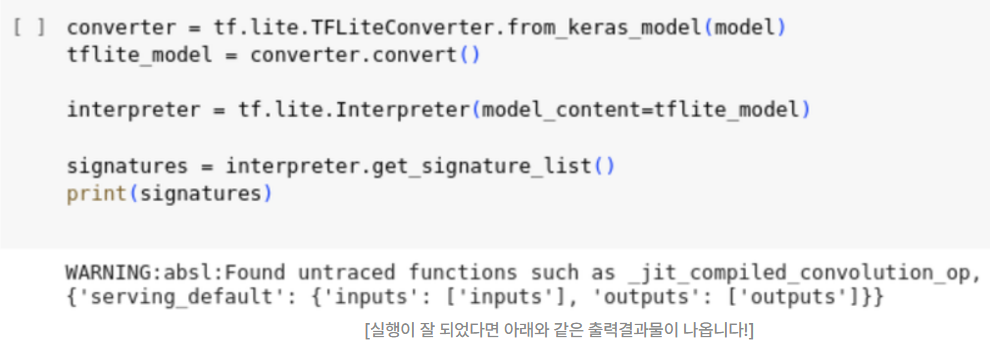

In [27]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

ValueError: Invalid signature_def_name provided.

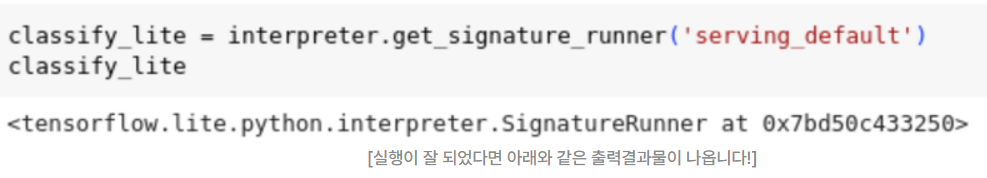

이렇듯 우리는 Flutter나 Kotlin으로 안드로이드 앱을 만들어서 휴대폰에서도 구동할 수 있게 만들 수 있습니다.